In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline



In [83]:
### Загрузка данных ###
source_df = pd.read_csv("clustering_test_work.csv")

# Для EDA делаем копию датафрейма и с ней будем работать.
eda_df = source_df.copy()

# Убираем столбцы Unnamed: 0  и customerID.
eda_df = source_df.drop(['Unnamed: 0'], axis=1, errors='ignore')

# Посмотрим на датасет и на типы данных по столбцам
eda_df.info()
eda_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247574 entries, 0 to 2247573
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   actual_id            int64  
 1   period_end           object 
 2   num                  int64  
 3   revenue_lastyear     float64
 4   quantity_lastyear    int64  
 5   orders_lastyear      int64  
 6   orders_refund        int64  
 7   ratio_not_dh         float64
 8   ratio_online         float64
 9   ratio_refund         float64
 10  avg_ratio_purchase   float64
 11  quantity_1st_period  float64
 12  unigenders           int64  
 13  recency              int64  
 14  aov                  float64
dtypes: float64(7), int64(7), object(1)
memory usage: 257.2+ MB


,actual_id,period_end,num,revenue_lastyear,quantity_lastyear,orders_lastyear,orders_refund,ratio_not_dh,ratio_online,ratio_refund,avg_ratio_purchase,quantity_1st_period,unigenders,recency,aov
2247569,998998908989,2022-05-18,9,82628.0,5,4,0,1.0,1.0,0.0,1.0,3.0,1,254,20657.00
2247570,998998908989,2022-07-18,10,87699.0,6,4,0,1.0,1.0,0.0,1.0,3.0,1,61,21924.75
2247571,998998908989,2022-09-18,11,14046.0,2,1,0,1.0,1.0,0.0,1.0,3.0,1,123,14046.00
2247572,998998908989,2022-11-18,12,14046.0,2,1,0,1.0,1.0,0.0,1.0,3.0,1,184,14046.00
2247573,998998908989,2022-12-07,13,14046.0,2,1,0,1.0,1.0,0.0,1.0,3.0,1,203,14046.00


In [ ]:
# Зависимость дохода за последний год от дней с последнего заказа
plt.scatter(eda_df.revenue_lastyear, eda_df.recency, s=40, c=eda_df.quantity_lastyear, marker='o', alpha=0.8)
plt.title('Зависимость дохода за последний год от дней с последнего заказа')
plt.xlabel('revenue_lastyear')
plt.ylabel('recency')
plt.show()

In [ ]:
# Посмотрим на первого клиента
eda_df[eda_df['actual_id'] == 12013601421]

In [ ]:
# Посмотрим на последнего клиента
eda_df[eda_df['actual_id'] == 998998908989]

In [ ]:
# Посмотрим на последний период
eda_df_num_13 = eda_df[eda_df['num'] == 13]
eda_df_num_13.head()

In [ ]:
# Оставляем тех клиентов, у которых есть заказы
eda_ne_0 = eda_df_num_13[eda_df_num_13['revenue_lastyear'] != 0]
eda_ne_0.head()

In [ ]:
# Посмотрим на описание датасета
eda_ne_0.describe()

In [ ]:
# Посмотрим клиентов, у которых более 100 заказов
eda_ne_0[eda_ne_0['orders_lastyear'] > 100]

In [3]:
# Удаляем клиентов с recency > 366
eda_df = eda_df[eda_df['recency'] < 366]

In [145]:
# Рассмотрим числовые данные 'aov', 'recency'

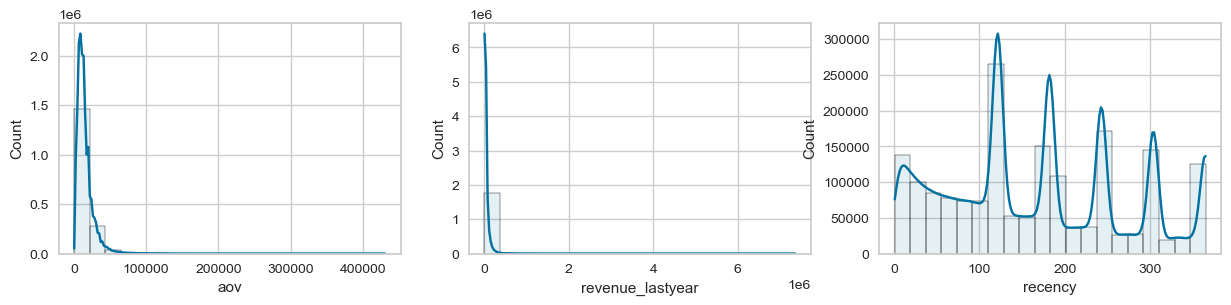

In [146]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
counter = 0
for name in eda_df[['aov','revenue_lastyear', 'recency']]:
    sns.histplot(eda_df[name],kde=True, bins=20, ax=ax[counter], label=name, alpha=0.1)
    counter+=1

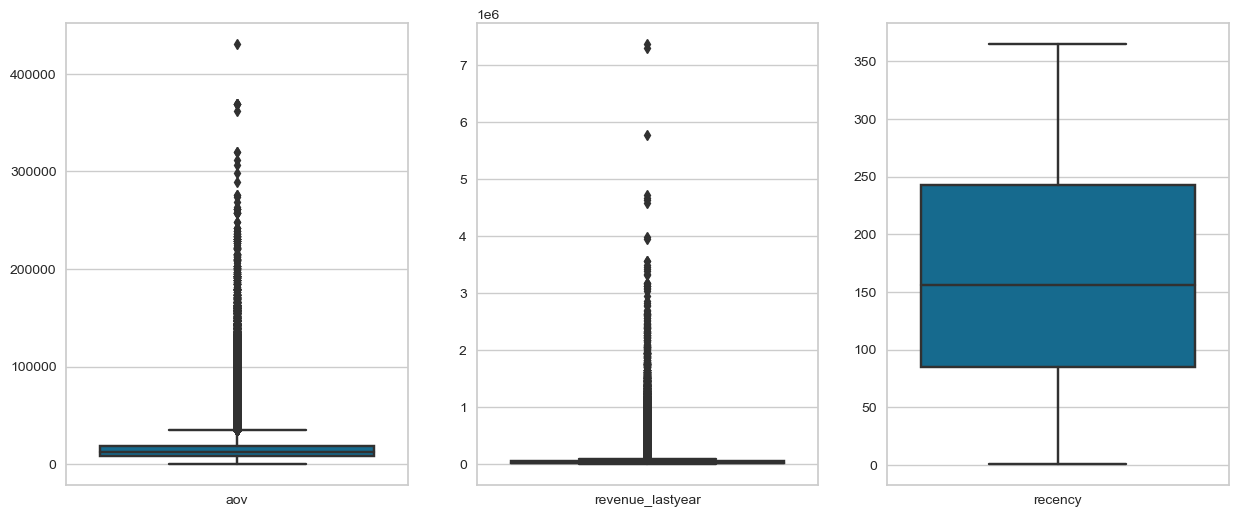

In [147]:
fig,ax = plt.subplots(1,3,figsize=(15,6))
sns.boxplot(data=eda_df['aov'], ax=ax[0])
sns.boxplot(data=eda_df['revenue_lastyear'], ax=ax[1])
sns.boxplot(data=eda_df['recency'], ax=ax[2])
ax[0].set_xticklabels(["aov"])
ax[1].set_xticklabels(["revenue_lastyear"])
ax[2].set_xticklabels(["recency"])
plt.show()

***Данные не распределены нормально. Наблюдаются выбросы***

In [4]:
# Определим супер-клиентов с aov > 60000 и отфильтруем датасет

eda_df = eda_df[(eda_df['revenue_lastyear'] < 62000) & (eda_df['aov'] < 30000)]

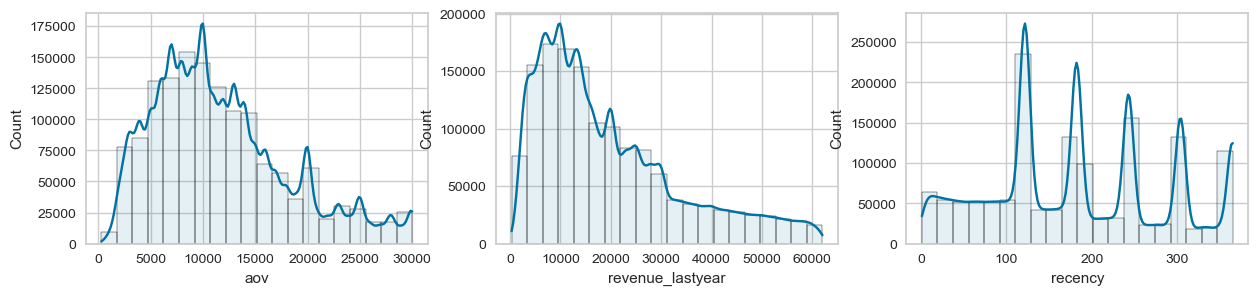

In [149]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
counter = 0
for name in eda_df[['aov','revenue_lastyear', 'recency']]:
    sns.histplot(eda_df[name],kde=True, bins=20, ax=ax[counter], label=name, alpha=0.1)
    counter+=1

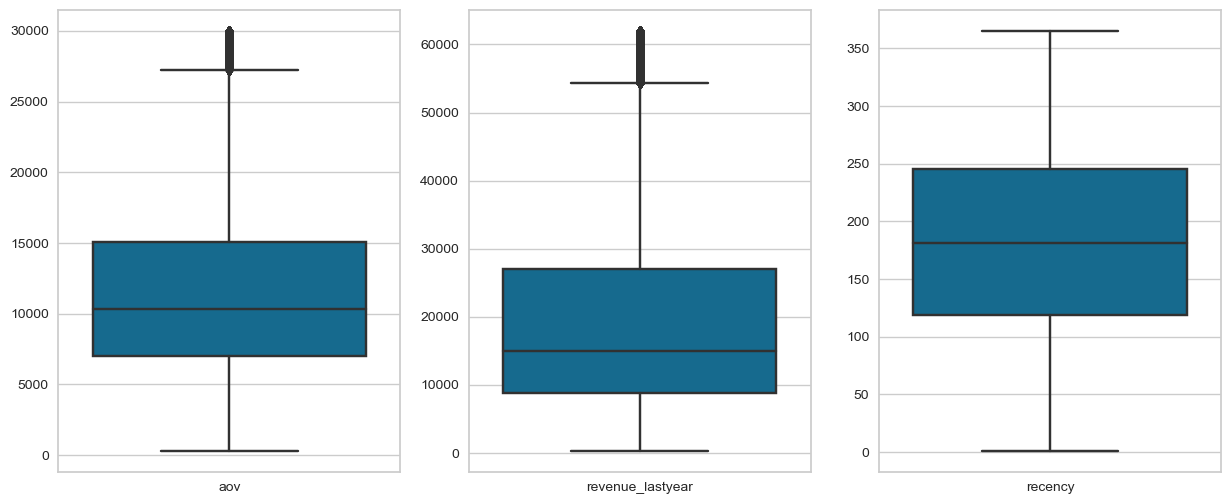

In [150]:
fig,ax = plt.subplots(1,3,figsize=(15,6))
sns.boxplot(data=eda_df['aov'], ax=ax[0])
sns.boxplot(data=eda_df['revenue_lastyear'], ax=ax[1])
sns.boxplot(data=eda_df['recency'], ax=ax[2])
ax[0].set_xticklabels(["aov"])
ax[1].set_xticklabels(["revenue_lastyear"])
ax[2].set_xticklabels(["recency"])
plt.show()

In [5]:
# Нормализуем данные с помощью RobustScaler
sr = RobustScaler()
eda_df[['aov_n', 'recency_n', 'revenue_lastyear_n']] = sr.fit_transform(eda_df[['aov', 'recency', 'revenue_lastyear']])
eda_df.head(3)

,actual_id,period_end,num,revenue_lastyear,quantity_lastyear,orders_lastyear,orders_refund,ratio_not_dh,ratio_online,ratio_refund,avg_ratio_purchase,quantity_1st_period,unigenders,recency,aov,aov_n,recency_n,revenue_lastyear_n
0,12013601421,2021-02-19,2,17920.0,4,1,0,1.0,1.0,0.0,0.8,4.0,1,123,17920.0,0.934378,-0.460317,0.161388
1,12013601421,2021-04-19,3,17920.0,4,1,0,1.0,1.0,0.0,0.8,4.0,1,182,17920.0,0.934378,0.007937,0.161388
2,12013601421,2021-06-19,4,17920.0,4,1,0,1.0,1.0,0.0,0.8,4.0,1,243,17920.0,0.934378,0.492063,0.161388


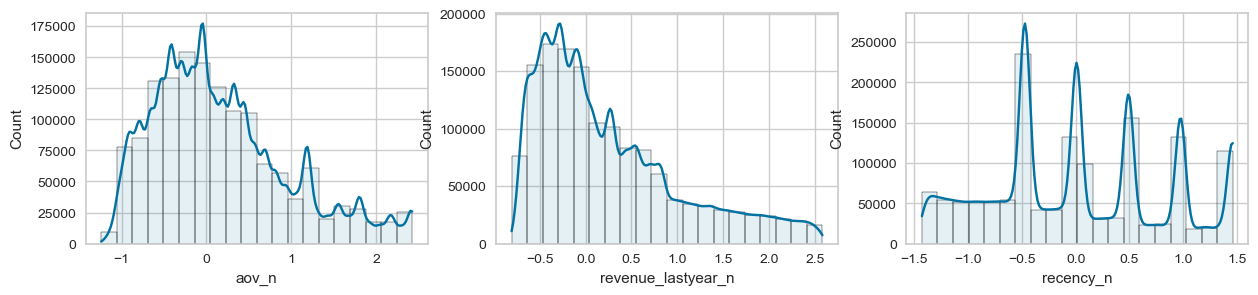

In [152]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
counter = 0
for name in eda_df[['aov_n','revenue_lastyear_n', 'recency_n']]:
    sns.histplot(eda_df[name],kde=True, bins=20, ax=ax[counter], label=name, alpha=0.1)
    counter+=1

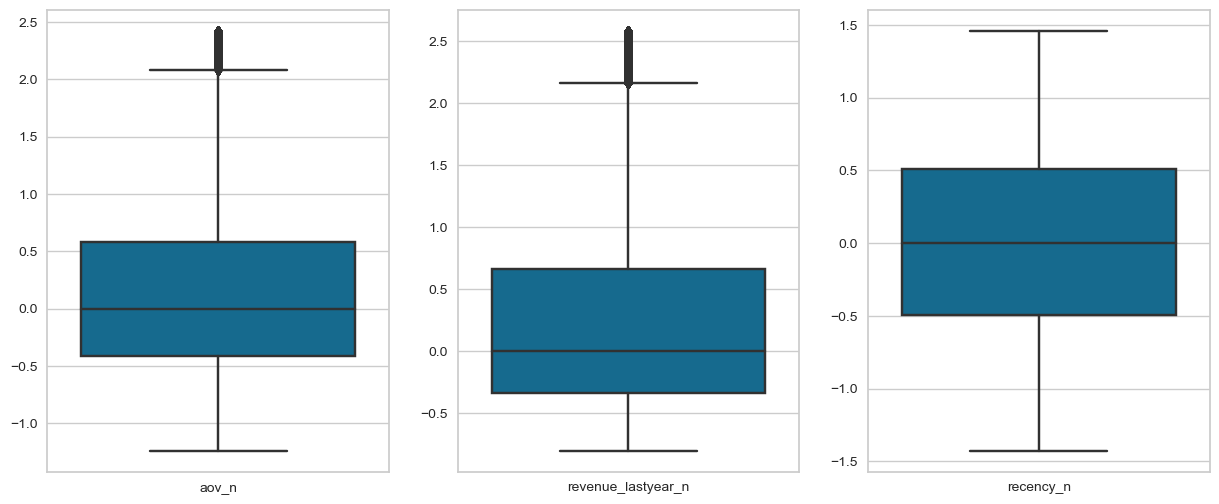

In [153]:
fig,ax = plt.subplots(1,3,figsize=(15,6))
sns.boxplot(data=eda_df['aov_n'], ax=ax[0])
sns.boxplot(data=eda_df['revenue_lastyear_n'], ax=ax[1])
sns.boxplot(data=eda_df['recency_n'], ax=ax[2])
ax[0].set_xticklabels(["aov_n"])
ax[1].set_xticklabels(["revenue_lastyear_n"])
ax[2].set_xticklabels(["recency_n"])
plt.show()

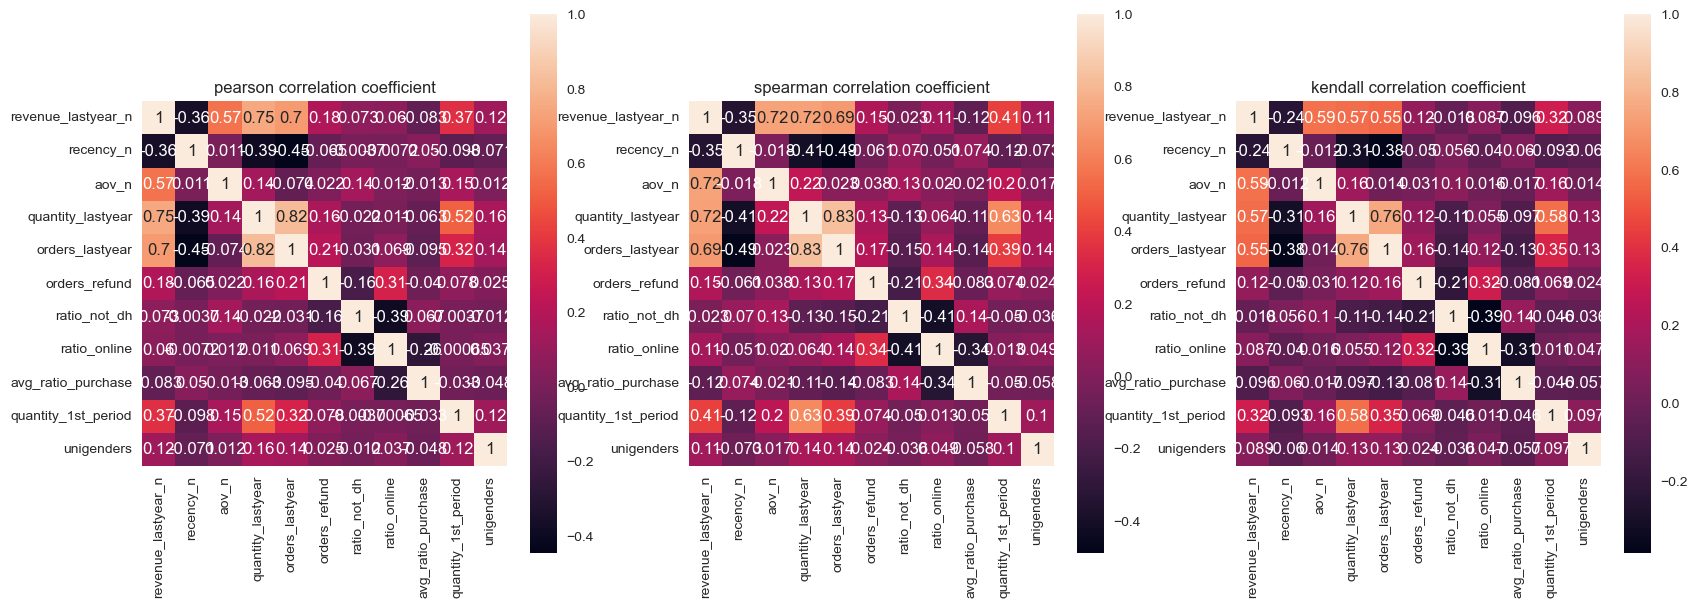

In [21]:
name_list = ['revenue_lastyear_n', 'recency_n', 'aov_n','quantity_lastyear', 'orders_lastyear', 'orders_refund', 'ratio_not_dh',
            'ratio_online', 'avg_ratio_purchase', 'quantity_1st_period', 'unigenders']
plt.figure(figsize=(20,7))
for num,name in enumerate(['pearson','spearman','kendall']):
    ax = plt.subplot(1,3,num+1)
    sns.heatmap(eda_df[name_list].corr(method=name), annot=True, square=True, ax=ax)
    plt.title(name+' correlation coefficient')

quantity_lastyear коррелирует с orders_lastyear, revenue_lastyear_n, aov_n, quantity_1st_period

### Обучаем *k-means* для количества кластеров $k=5$

In [22]:
X = eda_df[['revenue_lastyear_n', 'recency_n', 'orders_refund', 'ratio_not_dh', 
            'ratio_online', 'ratio_refund', 'avg_ratio_purchase']]

In [171]:
X = eda_df[['revenue_lastyear_n', 'recency_n', 'aov_n', 'quantity_lastyear', 'orders_lastyear', 
                     'orders_refund','num']]

Метод локтя для определения количества кластеров, которые должны быть сформированы:


C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

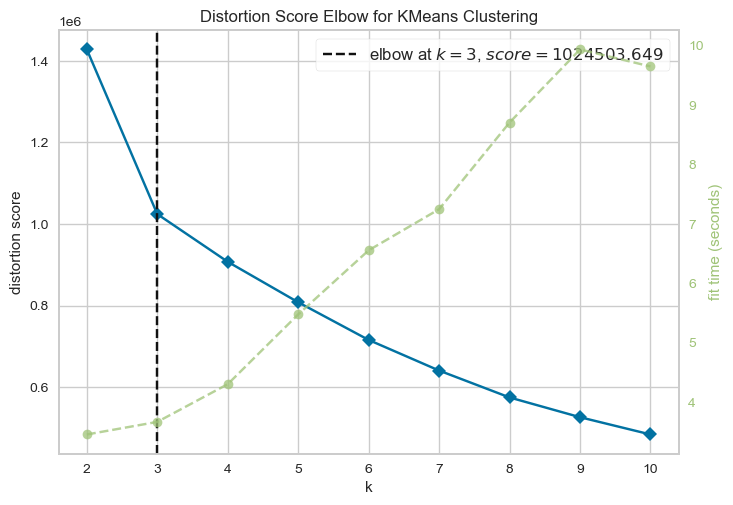

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
#метод локтя, чтобы найти количество кластеров для создания.
print('Метод локтя для определения количества кластеров, которые должны быть сформированы:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(X)
Elbow_M.show()

In [63]:
model = KMeans(n_clusters=5).fit(X)

C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


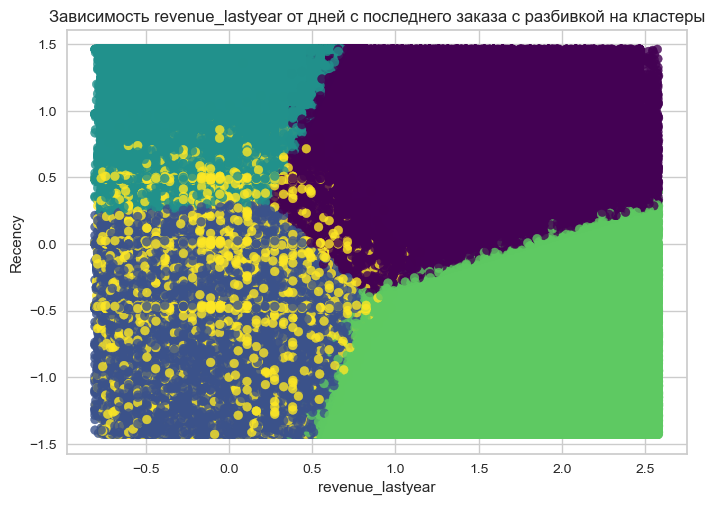

In [64]:
# Визуализируем зависимость revenue_lastyear от дней с последнего заказа с разбивкой на кластеры
plt.scatter(X['revenue_lastyear_n'], X['recency_n'], s=40, c=model.labels_, marker='o', alpha=0.8, cmap='viridis')
plt.title('Зависимость revenue_lastyear от дней с последнего заказа с разбивкой на кластеры')
plt.xlabel('revenue_lastyear')
plt.ylabel('Recency')
plt.show()

In [65]:
eda_df['Clasters'] = model.labels_

In [70]:
eda_df[(eda_df['Clasters'] == 4) & (eda_df['num'] == 13)]

,actual_id,period_end,num,revenue_lastyear,quantity_lastyear,orders_lastyear,orders_refund,ratio_not_dh,ratio_online,ratio_refund,avg_ratio_purchase,quantity_1st_period,unigenders,recency,aov,aov_n,recency_n,revenue_lastyear_n,Clasters
1174,16468949309,2022-11-15,13,11069.0,1,1,0,1.000000,1.000000,0.0,1.0,2.0,1,68,11069.0,0.089306,-0.896825,-0.214690,4
4584,31686298559,2022-11-06,13,7386.0,2,2,0,1.000000,1.000000,0.0,1.0,2.0,1,250,3693.0,-0.820525,0.547619,-0.416863,4
5702,35795910474,2022-12-07,13,2716.0,1,1,0,1.000000,1.000000,0.0,1.0,4.0,1,155,2716.0,-0.941039,-0.206349,-0.673217,4
9493,375296266306,2022-11-17,13,12980.0,1,1,0,1.000000,1.000000,0.0,1.0,1.0,1,7,12980.0,0.325028,-1.380952,-0.109788,4
10279,375296837287,2022-12-07,13,20748.0,3,2,1,1.000000,1.000000,0.5,1.0,2.0,1,236,10374.0,0.003577,0.436508,0.316627,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240100,79999874911,2022-12-01,13,5239.0,2,2,0,1.000000,0.666667,0.0,1.0,2.0,2,107,2619.5,-0.952942,-0.587302,-0.534720,4
2240400,79999892653,2022-12-06,13,14909.0,3,1,1,0.794239,1.000000,1.0,1.0,4.0,1,169,14909.0,0.562970,-0.095238,-0.003897,4
2242715,9109005587,2022-12-07,13,17980.0,1,1,0,1.000000,1.000000,0.0,1.0,3.0,1,23,17980.0,0.941779,-1.253968,0.164681,4
2246746,995511108968,2022-12-07,13,17695.0,1,1,0,1.000000,1.000000,0.0,1.0,4.0,1,169,17695.0,0.906624,-0.095238,0.149037,4


Кластер 0: фиолетовый. Зона риска. Большие заказы. Достаточно большое число дней от даты последнего заказа


Кластер 1: желтый. Новички. Приносят низкий доход, имеют небольшое число заказов. Достаточно большое число дней от даты последнего заказа


Кластер 2: темно зеленый. Спящие. Число заказов и доход стремятся к нулю,
очень большое число дней от даты последнего заказа

Кластер 3: зеленый. Крутые. Делают много заказов, но не так регулярно, как бы хотелось, увеличение потребления


Кластер 4: синий.Типичные. Средние число заказов и доход, сохраняют объём покупок


In [77]:
print('{} клиентов находятся в предоттоке'.format(eda_df[(eda_df['Clasters'] == 0) & (eda_df['num'] == 13)].shape[0]))

2520 клиентов находятся в предоттоке


In [78]:
print('{} клиентов находятся в оттоке'.format(eda_df[(eda_df['Clasters'] == 2) & (eda_df['num'] == 13)].shape[0]))

4039 клиентов находятся в оттоке


In [84]:
top_client = source_df[(source_df['revenue_lastyear'] > 62000) & (source_df['aov'] > 30000)]
top_client.head()

,Unnamed: 0,actual_id,period_end,num,revenue_lastyear,quantity_lastyear,orders_lastyear,orders_refund,ratio_not_dh,ratio_online,ratio_refund,avg_ratio_purchase,quantity_1st_period,unigenders,recency,aov
154,154,12124442520,2021-01-10,2,147751.0,10,1,0,1.0,0.0,0.0,1.0,10.0,1,122,147751.0
155,155,12124442520,2021-03-10,3,147751.0,10,1,0,1.0,0.0,0.0,1.0,10.0,1,181,147751.0
156,156,12124442520,2021-05-10,4,147751.0,10,1,0,1.0,0.0,0.0,1.0,10.0,1,242,147751.0
157,157,12124442520,2021-07-10,5,147751.0,10,1,0,1.0,0.0,0.0,1.0,10.0,1,303,147751.0
158,158,12124442520,2021-09-10,6,151981.0,12,2,0,1.0,0.0,0.0,1.0,10.0,1,25,75990.5


In [85]:
top_client.describe()

,Unnamed: 0,actual_id,num,revenue_lastyear,quantity_lastyear,orders_lastyear,orders_refund,ratio_not_dh,ratio_online,ratio_refund,avg_ratio_purchase,quantity_1st_period,unigenders,recency,aov
count,6.778800e+04,6.778800e+04,67788.00000,6.778800e+04,67788.000000,67788.000000,67788.000000,67788.000000,67788.000000,67788.000000,67788.000000,67788.000000,67788.000000,67788.000000,67788.000000
mean,1.096709e+06,3.992830e+13,5.88706,1.515017e+05,12.149968,3.532380,0.294551,0.994480,0.291427,0.068161,0.952471,5.922877,1.131513,122.048829,48522.001743
std,6.607785e+05,4.155682e+15,3.23565,1.546532e+05,13.838093,3.747425,1.256536,0.027955,0.375830,0.192281,0.162347,5.997352,0.337963,98.090223,23026.272921
min,1.540000e+02,9.122859e+08,2.00000,6.200700e+04,1.000000,1.000000,0.000000,0.486836,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,30001.000000
25%,5.212358e+05,7.911925e+10,3.00000,7.703600e+04,5.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,38.000000,33930.000000
50%,1.099004e+06,7.919390e+10,5.00000,1.053835e+05,8.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,4.000000,1.000000,101.000000,39648.000000
75%,1.659656e+06,7.937810e+10,8.00000,1.646762e+05,14.000000,4.000000,0.000000,1.000000,0.500000,0.000000,1.000000,8.000000,1.000000,182.000000,55328.375000
max,2.247561e+06,4.414819e+17,14.00000,4.708876e+06,359.000000,122.000000,69.000000,1.000000,1.000000,1.000000,1.000000,138.000000,2.000000,365.000000,430790.000000


Топовые клиенты в среднем имеют более 10 заказов в месяц и aov > 48 000